In [2]:
import pandas as pd

In [31]:
macro = pd.read_csv("/kaggle/input/dat-full-macro/macroeconomic_full_time_series (1).csv", index_col=0)

In [32]:
macro['Date'] = pd.PeriodIndex(macro['Date'], freq='Q')

macro = macro.sort_values(by='Date').reset_index(drop=True)

In [33]:
macro.set_index(["Date"], inplace=True)
macro.index = macro.index.astype(str)

In [34]:
from statsmodels.tsa.stattools import adfuller

for variable in macro.columns:

    # Perform the ADF test
    result = adfuller(macro[variable].dropna())

    # Extract and print the p-value from the test result
    p_value = result[1]
    print("p-value:", p_value)

    # Interpret the result
    if p_value <= 0.05:
        print(f"The variable {variable} is stationary.\n")
    else:
        print(f"The variable {variable} is not stationary.\n")

p-value: 1.0
The variable Real Estate Activitie is not stationary.

p-value: 0.999067143380585
The variable Domestic Liquidity is not stationary.

p-value: 1.0
The variable Money Supply is not stationary.

p-value: 0.6053653202343944
The variable Points is not stationary.

p-value: 0.036404831811835126
The variable Inflation Rate is stationary.



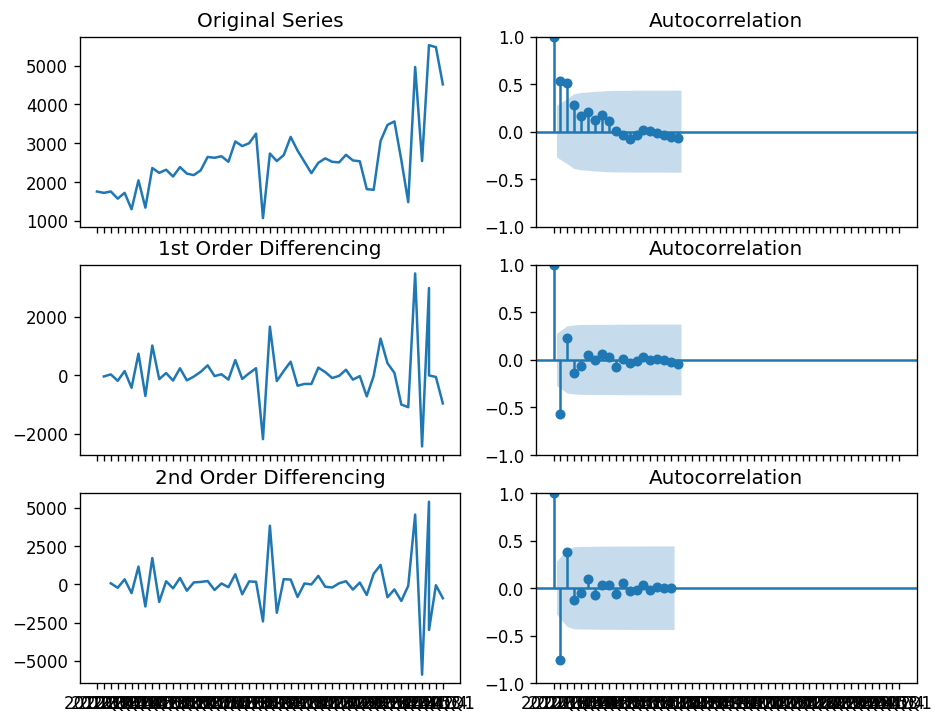

In [36]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

col = macro["Points"].dropna()

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(col); axes[0, 0].set_title('Original Series')
plot_acf(col, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(col.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(col.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(col.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(col.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

In [37]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 23.0 MB/s eta 0:00:0000:0100:01


In [76]:
macro.index = pd.PeriodIndex(macro.index, freq='Q')

In [86]:
from statsmodels.tsa.arima_model import ARIMA

import pmdarima as pm

macro_pred = pd.DataFrame()

for macro_col in macro.columns:
    print("----------", macro_col, "----------")
    model = pm.auto_arima(macro[macro_col].dropna(), start_p=1, start_q=1,
                          test='adf',       # use adftest to find optimal 'd'
                          max_p=12, max_q=12, # maximum p and q
                          m=1,              # frequency of series
                          d=None,           # let model determine 'd'
                          seasonal=False,   # No Seasonality
                          start_P=0, 
                          D=0, 
                          trace=True,
                          error_action='ignore',  
                          suppress_warnings=True, 
                          stepwise=True)
    
    print(model.summary())
    pred = model.predict(n_periods=12)
    df = pred.to_frame(name=macro_col)
    macro_pred = pd.concat([macro_pred, df], axis=1)

---------- Real Estate Activitie ----------
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1961.568, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1958.465, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1960.397, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1960.230, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1968.711, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.152 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   94
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -977.233
Date:                Tue, 11 Mar 2025   AIC                           1958.465
Time:                        11:18:05   BIC                           1963.530
Sample:                    03-31-2002   HQIC                          1960.510
                         - 03-31

In [87]:
macro_pred

,Real Estate Activitie,Domestic Liquidity,Money Supply,Points,Inflation Rate
2025Q3,315639.219355,8.204139e+06,1.963101e+06,4868.078975,1.368196
2025Q4,318961.088710,8.311808e+06,1.985513e+06,4933.345558,1.278795
2026Q1,322282.958065,8.408127e+06,2.007925e+06,4998.612141,1.251405
2026Q2,325604.827419,8.501090e+06,2.030338e+06,5063.878724,1.243014
2026Q3,328926.696774,8.593061e+06,2.052750e+06,5129.145306,1.240443
2026Q4,332248.566129,8.684738e+06,2.075162e+06,5194.411889,1.239655
2027Q1,335570.435484,8.776329e+06,2.097574e+06,5259.678472,1.239414
2027Q2,338892.304839,8.867894e+06,2.119986e+06,5324.945055,1.239340
2027Q3,342214.174194,8.959451e+06,2.142399e+06,5390.211637,1.239317
2027Q4,345536.043548,9.051006e+06,2.164811e+06,5455.478220,1.239310


In [88]:
macro_pred.to_csv("macro_pred_2025_2028.csv")